<a href="https://colab.research.google.com/github/Luis98ros/Neuronal-Networks/blob/main/Neuronal_Network_Language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import gensim  # para cargar modelo w2v
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import contractions
import re
import tensorflow
import numpy as np
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

In [ ]:
def vocabulario(pandas_series):
    lista_palabras = " ".join(sec for sec in pandas_series).split(" ")
    x = Counter(lista_palabras)

    return [i for i,_ in x.most_common() ]

In [ ]:
def elimina_puntuacion_y_numeros(texto):
  nuevo_texto = re.sub(r'[^\w]', ' ', texto)
  return nuevo_texto

In [ ]:
def preprocesar(texto):
  texto = contractions.fix(texto)
  texto = elimina_puntuacion_y_numeros(texto)
  return(texto)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML Datos/Examen Modulo 3/deceptive-opinion.csv", usecols = ["deceptive","text"])
df.head()

,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [ ]:
df.shape

(1600, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   text       1600 non-null   object
dtypes: object(2)
memory usage: 25.1+ KB


In [ ]:
df.nunique()

,0
deceptive,2
text,1596


In [ ]:
df.deceptive.value_counts()

,count
deceptive,
truthful,800
deceptive,800


In [ ]:
df.text

,text
0,We stayed for a one night getaway with family ...
1,Triple A rate with upgrade to view room was le...
2,This comes a little late as I'm finally catchi...
3,The Omni Chicago really delivers on all fronts...
4,I asked for a high floor away from the elevato...
...,...
1595,Problems started when I booked the InterContin...
1596,The Amalfi Hotel has a beautiful website and i...
1597,The Intercontinental Chicago Magnificent Mile ...
1598,"The Palmer House Hilton, while it looks good i..."


In [ ]:
df['text_pp'] = df['text'].apply(preprocesar)
df.head()

,deceptive,text,text_pp
0,truthful,We stayed for a one night getaway with family ...,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...,This comes a little late as I am finally catch...
3,truthful,The Omni Chicago really delivers on all fronts...,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...,I asked for a high floor away from the elevato...


In [ ]:
vocabulario_palabras = vocabulario(df["text_pp"])
vocabulario_tags = vocabulario(df["deceptive"])

In [ ]:
vocabulario_palabras

['',
 'the',
 'and',
 'to',
 'I',
 'a',
 'was',
 'in',
 'of',
 'The',
 'for',
 'hotel',
 'room',
 'not',
 'is',
 'at',
 'it',
 'we',
 'that',
 'my',
 'were',
 'with',
 'had',
 'on',
 'Chicago',
 'have',
 'but',
 'this',
 'stay',
 'very',
 'our',
 'We',
 'you',
 'they',
 'would',
 'be',
 'there',
 'as',
 'from',
 'are',
 'all',
 'me',
 'staff',
 'great',
 'service',
 'so',
 'did',
 'one',
 'rooms',
 'out',
 'an',
 'stayed',
 'will',
 'up',
 'when',
 'us',
 'night',
 'could',
 'Hotel',
 'like',
 'get',
 'It',
 'no',
 'time',
 'desk',
 'about',
 'just',
 'or',
 'My',
 'again',
 'nice',
 'which',
 'by',
 'bed',
 'location',
 'only',
 'even',
 'here',
 'do',
 'clean',
 'This',
 'got',
 'back',
 'front',
 'good',
 'if',
 'more',
 'their',
 'been',
 'place',
 'When',
 'some',
 'check',
 'day',
 'also',
 'bathroom',
 'They',
 'than',
 'experience',
 'what',
 's',
 'well',
 'friendly',
 'other',
 'made',
 'really',
 'next',
 'comfortable',
 'because',
 'two',
 'go',
 'recommend',
 'hotels',
 'h

In [ ]:
len(vocabulario_palabras),len(vocabulario_tags)

(11111, 2)

In [ ]:
#df["text"] = df["text"].apply(lambda x: x.replace("\n",""))

In [ ]:
df.loc[446,"text_pp"]

'Fantastic Hotel  Upscale and luxurious  and in a great location  Rooms are spacious and comfortable and the staff goes out of their way to treat guests like royalty  The rooms are tastefully decorated and very clean  the beds are comfortable and even the bathrooms were to die for  My husband and I had a great time in the lounge and enjoyed many of the amenities  I would definitely recommend this hotel to everyone  and cannot wait to get back there myself  '

In [ ]:
def get_dict_map(token_or_tag):
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de
        # tokens
        vocab = ['PAD_token'] + vocabulario(df['text_pp'])
    elif token_or_tag == 'tag':
        vocab = vocabulario(df['deceptive'])

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map('token')
tag2idx, idx2tag = get_dict_map('tag')

In [ ]:
token2idx['dissapointed'],len(token2idx)

(3365, 11112)

In [ ]:
tag2idx["truthful"]

0

In [ ]:
n_tags = len(tag2idx)
n_tags

2

In [ ]:
df['text_idx'] = df['text_pp'].apply(lambda x: list(map(token2idx.get, x.split())))
df['Tags_idx'] = df['deceptive'].apply(lambda x: list(map(tag2idx.get, x.split())))
df

,deceptive,text,text_pp,text_idx,Tags_idx
0,truthful,We stayed for a one night getaway with family ...,We stayed for a one night getaway with family ...,"[32, 52, 11, 6, 48, 57, 712, 22, 238, 24, 6, 4...",[0]
1,truthful,Triple A rate with upgrade to view room was le...,Triple A rate with upgrade to view room was le...,"[3631, 275, 277, 22, 641, 4, 121, 13, 7, 413, ...",[0]
2,truthful,This comes a little late as I'm finally catchi...,This comes a little late as I am finally catch...,"[81, 1167, 6, 215, 391, 38, 5, 116, 267, 4425,...",[0]
3,truthful,The Omni Chicago really delivers on all fronts...,The Omni Chicago really delivers on all fronts...,"[10, 316, 25, 106, 3634, 24, 41, 4427, 39, 2, ...",[0]
4,truthful,I asked for a high floor away from the elevato...,I asked for a high floor away from the elevato...,"[5, 160, 11, 6, 224, 126, 171, 39, 2, 459, 3, ...",[0]
...,...,...,...,...,...
1595,deceptive,Problems started when I booked the InterContin...,Problems started when I booked the InterContin...,"[3484, 717, 55, 5, 158, 2, 613, 25, 561, 16, 2...",[1]
1596,deceptive,The Amalfi Hotel has a beautiful website and i...,The Amalfi Hotel has a beautiful website and i...,"[10, 386, 59, 114, 6, 174, 307, 3, 2150, 2848,...",[1]
1597,deceptive,The Intercontinental Chicago Magnificent Mile ...,The Intercontinental Chicago Magnificent Mile ...,"[10, 984, 25, 571, 419, 10, 410, 9, 2, 12, 359...",[1]
1598,deceptive,"The Palmer House Hilton, while it looks good i...",The Palmer House Hilton while it looks good i...,"[10, 505, 448, 185, 159, 17, 707, 85, 8, 812, ...",[1]


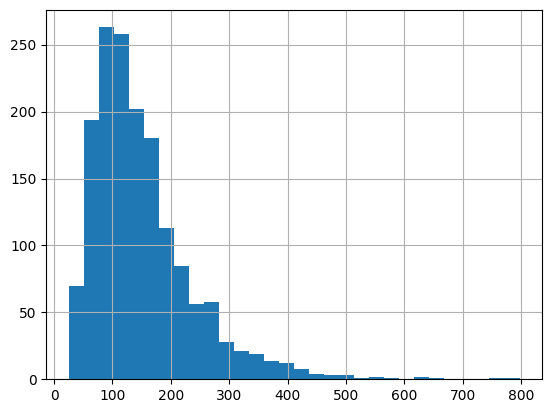

La oración más larga tiene 797 tokens


In [ ]:
palabras_sentencia = df['text_pp'].apply(lambda x: len(str(x).split()))

palabras_sentencia.hist(bins=30)
plt.show()
print('La oración más larga tiene {} tokens'.format(palabras_sentencia.max()))

In [ ]:
max_len = int(palabras_sentencia.quantile(0.995))
max_len

526

In [ ]:
pad_tokens = pad_sequences(df['text_idx'], maxlen=max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])
pad_tags = pad_sequences(df['Tags_idx'], maxlen=max_len,
                         dtype='int32', padding='post',
                         value= tag2idx["truthful"])

# Hacemos un One Hot Encoding para la secuencia de etiquetas
pad_tags = [to_categorical(i, num_classes=len(tag2idx)) for i in pad_tags]

In [ ]:
len(pad_tokens)

1600

In [ ]:
for token, tag in zip(pad_tokens[2], pad_tags[2]):
    print('%s\t%s' % (token, tag))

81	[1. 0.]
1167	[1. 0.]
6	[1. 0.]
215	[1. 0.]
391	[1. 0.]
38	[1. 0.]
5	[1. 0.]
116	[1. 0.]
267	[1. 0.]
4425	[1. 0.]
54	[1. 0.]
24	[1. 0.]
20	[1. 0.]
323	[1. 0.]
39	[1. 0.]
2	[1. 0.]
624	[1. 0.]
308	[1. 0.]
1105	[1. 0.]
275	[1. 0.]
3632	[1. 0.]
652	[1. 0.]
3	[1. 0.]
5	[1. 0.]
52	[1. 0.]
16	[1. 0.]
2	[1. 0.]
347	[1. 0.]
643	[1. 0.]
8	[1. 0.]
391	[1. 0.]
2419	[1. 0.]
1897	[1. 0.]
11	[1. 0.]
48	[1. 0.]
57	[1. 0.]
159	[1. 0.]
500	[1. 0.]
6	[1. 0.]
652	[1. 0.]
3	[1. 0.]
256	[1. 0.]
164	[1. 0.]
39	[1. 0.]
50	[1. 0.]
9	[1. 0.]
463	[1. 0.]
81	[1. 0.]
12	[1. 0.]
15	[1. 0.]
251	[1. 0.]
5	[1. 0.]
1514	[1. 0.]
4426	[1. 0.]
2726	[1. 0.]
2727	[1. 0.]
93	[1. 0.]
8	[1. 0.]
3	[1. 0.]
93	[1. 0.]
50	[1. 0.]
2420	[1. 0.]
80	[1. 0.]
108	[1. 0.]
49	[1. 0.]
22	[1. 0.]
44	[1. 0.]
424	[1. 0.]
9	[1. 0.]
2	[1. 0.]
130	[1. 0.]
5	[1. 0.]
252	[1. 0.]
28	[1. 0.]
129	[1. 0.]
464	[1. 0.]
102	[1. 0.]
3	[1. 0.]
17	[1. 0.]
15	[1. 0.]
30	[1. 0.]
598	[1. 0.]
4	[1. 0.]
178	[1. 0.]
180	[1. 0.]
25	[1. 0.]
623	[1. 0.]
32	[1. 0.

In [ ]:
#file =  '/content/drive/MyDrive/ML Datos/Examen Modulo 3/GoogleNews-vectors-negative300.bin.gz'
#w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)

In [ ]:
#dic_tokens_word2vec  = {}
#palabras_sin_embedding =[]
#for token in vocabulario_palabras:
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     palabras_sin_embedding.append(token)

In [ ]:
#import pickle
#path = '/content/drive/MyDrive/ML Datos/Examen Modulo 3'
#pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_ner_w2v.pkl", 'wb'))

In [ ]:
import pickle
path = '/content/drive/MyDrive/ML Datos/Examen Modulo 3'
dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_ner_w2v.pkl", 'rb'))
palabras_sin_embedding = [tok for tok in vocabulario_palabras if tok not in dic_tokens_word2vec.keys()]

In [ ]:
len(vocabulario_palabras)

11111

In [ ]:
voc_pal = pd.DataFrame(vocabulario_palabras, columns = ["palabra"])

In [ ]:
len(palabras_sin_embedding)

2183

In [ ]:
palabras_sin_embedding

['',
 'and',
 'to',
 'a',
 'of',
 '10',
 '30',
 '20',
 '15',
 '00',
 '24',
 '50',
 '100',
 'fi',
 'wi',
 '40',
 '200',
 '45',
 '11',
 '25',
 'O',
 'Wi',
 '14',
 'Fi',
 '12',
 'e',
 '13',
 '300',
 'c',
 '99',
 'com',
 '400',
 '10th',
 '42',
 'pre',
 'm',
 '2010',
 'travelling',
 'Cannot',
 '17',
 '2007',
 'w',
 '75',
 '16',
 '80',
 'Additionally',
 '30pm',
 '48',
 '29th',
 '35',
 '2009',
 'p',
 '30am',
 'Shula',
 'Europe',
 '70',
 '250',
 'theatre',
 '65',
 'shape',
 'centre',
 'Pros',
 '95',
 '22nd',
 'Hare',
 'allergenic',
 'S',
 'C',
 '18',
 '55',
 'WOW',
 '49',
 'travelzoo',
 '2008',
 '11th',
 'mail',
 'wow',
 'yeah',
 'jobs',
 'cancelled',
 'penny',
 '60',
 '500',
 '676',
 '21st',
 'M',
 '14th',
 'travelled',
 '20th',
 '22',
 'fairmont',
 '15th',
 'd',
 '42nd',
 'liking',
 'co',
 'theatres',
 '27',
 'b',
 'Mr',
 '312',
 '90',
 '32',
 'summary',
 'deceiving',
 '25th',
 '000',
 'smoothly',
 'Joe',
 '69',
 '23rd',
 'AMAZING',
 'Fortunately',
 '89',
 'Sure',
 'consierge',
 '350',
 'She

In [ ]:
voc_pal[voc_pal.palabra.isin(palabras_sin_embedding)]['palabra'].value_counts(normalize=True).cumsum().head(35)

,proportion
palabra,
,0.000458
England,0.000916
rightfully,0.001374
defiant,0.001832
websight,0.002290
attractiion,0.002749
lobbie,0.003207
World,0.003665
appalling,0.004123


In [ ]:
len(voc_pal[voc_pal.palabra.isin(dic_tokens_word2vec)]['palabra'].unique())

8928

In [ ]:
len(token2idx)

11112

In [ ]:
num_tokens = len(token2idx)
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token2idx.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]

In [ ]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.080078,0.104980,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.071289,-0.030151,-0.013000,0.016357,-0.018311,0.014832,0.005005,0.003662,0.047607,-0.068848
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11107,-0.036865,0.205078,0.086914,-0.051758,0.067871,0.092285,-0.027466,0.390625,0.474609,0.259766,...,0.054932,0.023071,0.182617,0.154297,-0.263672,0.285156,-0.228516,0.061523,-0.026978,0.204102
11108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11110,-0.449219,0.185547,-0.013367,0.115723,-0.056396,-0.143555,-0.369141,0.083984,0.074707,-0.324219,...,0.076172,0.016724,0.158203,-0.086426,-0.361328,0.124512,-0.163086,0.177734,-0.060059,0.333984


In [ ]:
train_tokens, test_tokens, train_tags, test_tags = train_test_split(
pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=1998)

print(
f'''train_tokens: {len(train_tokens)}
train_tags: {len(train_tags)}

test_tokens: {len(test_tokens)}
test_tags: {len(test_tags)}'''
)

train_tokens: 1440
train_tags: 1440

test_tokens: 160
test_tags: 160


In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      embeddings_initializer = Constant(embedding_matrix),
                      trainable=False)(input)
# Capa 1 LSTM Bidireccional
LSTM_Bi = Bidirectional(LSTM(units=128,
                             return_sequences=True, # Todos los estados h para cada timestep
                             recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                             ))(embedding)
# Capa de Salida
out = TimeDistributed(
    Dense(n_tags,               # dimensiones de salida (17 clases de los Tags)
          activation="softmax"  # para obtener una probabilidad para cada clase
                                # función de activación
                                # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          ))(LSTM_Bi)

NER_model = Model(input, out)  # unión del modelo
NER_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 526)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 526, 300)            │       3,333,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 526, 256)            │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 526, 2)              │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,773,410 (14.39 MB)

 Trainable params: 439,810 (1.68 MB)

 Non-trainable params: 3,333,600 (12.72 MB)

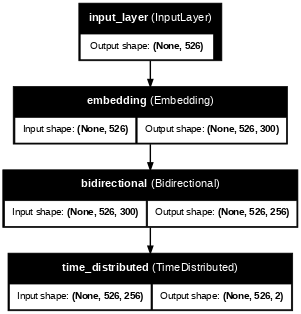

In [ ]:
plot_model(
    NER_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
# Compile model
NER_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="categorical_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [ ]:
history = NER_model.fit(train_tokens, np.array(train_tags),
                        validation_split=0.2,
                        batch_size=200,
                        epochs=1,   # número de iteraciones sobre los datos
                        verbose=1)

In [ ]:
test_pred = NER_model.predict(np.array(test_tokens), verbose=1)

In [ ]:
# Dimensiones de salida
test_pred.shape

In [ ]:
test_pred[0].shape

In [ ]:
pd.DataFrame(test_pred[0])

In [ ]:
test_tokens[0:2] # Primeras dos secuencias de entrada en test

In [ ]:
def secIdx2secTok(M):
  n = M.shape[0]
  d = M.shape[1]
  oraciones = []
  for i in range(n):
      tokens = []
      for j in range(d):
          idx = M[i, j]
          tokens.append(idx2token[idx])
      oraciones.append(tokens)
  return oraciones

test_toks = secIdx2secTok(test_tokens)

In [ ]:

def secIdx2secTag(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out



pred_labels = secIdx2secTag(test_pred)
test_labels = secIdx2secTag(test_tags)

In [ ]:
dfs = {}
for idx in range(len(test_labels)):
  dfs[idx] = pd.DataFrame({'ID': idx, 'Word': test_toks[idx],
                           'Pred':pred_labels[idx], 'Tag':test_labels[idx]})

resultados = pd.concat(dfs, ignore_index = True).set_index('ID')
resultados = resultados[resultados['Word']!='PAD_token']
resultados['acierto'] = np.where(resultados['Pred']==resultados['Tag'],1,0)
resultados['acierto'].mean()

In [ ]:
resultados.loc[312]  # 4 , 8 , 87